# IMRT fluence maps and the power of transfer learning

The goal of this notebook is to predict gamma index values of calculated fluence maps in IMRT.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

Fluence maps are read from JPEG files, which are generated from DICOM files in RT Dose format, using __fluence_maps/util/dicom2jpeg.py__

In [3]:
np.random.seed(12345)
PATH = Path("/home/pablo/datasets/data/radioterapia/ciolaplata/")
path = PATH/"2018-jpeg/"
path2 = PATH/"2019-jpeg/"
list_all = list(path.iterdir())+list(path2.iterdir())
random.shuffle(list_all)
list_all[:10]

[PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2018-jpeg/1.3.6.1.4.1.9590.100.1.2.64421801711636623808828443423123138967.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-jpeg/1.3.6.1.4.1.9590.100.1.2.217810440312374316116461127011521168136.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2018-jpeg/1.3.6.1.4.1.9590.100.1.2.321147725811938695101536444513293432581.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-jpeg/1.3.6.1.4.1.9590.100.1.2.304275504210078777001252975971455271810.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2018-jpeg/1.3.6.1.4.1.9590.100.1.2.175014881511127316913354234003438051973.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-jpeg/1.3.6.1.4.1.9590.100.1.2.357807871711095388221318908644010339204.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2018-jpeg/1.3.6.1.4.1.9590.100.1.2.3468037898113087781400458616408620

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return im

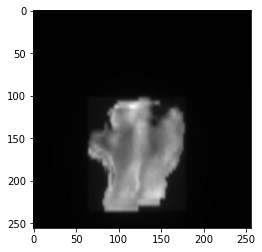

In [5]:
path = PATH/"2018-jpeg/1.3.6.1.4.1.9590.100.1.2.310116611339769406079254153056253359.jpeg"
im = read_image(path)
plt.imshow(im)

In [6]:
im = cv2.imread(str(path))
im.shape

(256, 256, 3)

In [7]:
# let's look at the typical size of these images
files = list_all[:1000]
dims = [read_image(str(p)).shape for p in files]

In [8]:
np.unique(dims)

array([  3, 256])

Amazing! all images have the same size.

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification task

_Pablo: Don't do data augmentation for fluence maps_

## Split train and validation

_Pablo: Not all fluence map files have a gamma value in the gamma .csv file, so we need to split the gamma .csv file and not the map files in the file system._

In [9]:
# from sklearn.model_selection import train_test_split
# all_files = list(PATH.iterdir())
# X_train, X_test = train_test_split(all_files, test_size=0.2, random_state=12345)

In [10]:
# print(len(X_train), len(X_test))

In [11]:
maps_in = pd.read_csv(PATH/"codex.2018-2019.csv", sep=';', delimiter=None, header=0)
maps_in.head()

,año,fluencia medida,fluencia calculada,uno menos gamma index
0,2019,1.3.6.1.4.1.9590.100.1.2.106363004312018285639...,1.3.6.1.4.1.9590.100.1.2.250681179813913418312...,0.126820
1,2019,1.3.6.1.4.1.9590.100.1.2.117111588412865729801...,1.3.6.1.4.1.9590.100.1.2.189485955411711008602...,0.004941
2,2019,1.3.6.1.4.1.9590.100.1.2.190727149413805451333...,1.3.6.1.4.1.9590.100.1.2.266447459412025533907...,0.541950
3,2019,1.3.6.1.4.1.9590.100.1.2.211756715011326913522...,1.3.6.1.4.1.9590.100.1.2.310552899912770926928...,0.000000
4,2019,1.3.6.1.4.1.9590.100.1.2.225990696211768600614...,1.3.6.1.4.1.9590.100.1.2.384142289612482598518...,0.406440


In [12]:
maps_out = pd.DataFrame(columns=['full_filename_jpeg', 'gamma_index'])
maps_out['full_filename_jpeg'] = [PATH/Path(str(row[0])+'-jpeg')/Path(str(row[1])+'.jpeg') for row in maps_in[['año', 'fluencia calculada']].values]
maps_out['gamma_index'] = maps_in.apply(lambda row: 100.0 - row['uno menos gamma index'], axis=1)
maps_out.head()

,full_filename_jpeg,gamma_index
0,/home/pablo/datasets/data/radioterapia/ciolapl...,99.873180
1,/home/pablo/datasets/data/radioterapia/ciolapl...,99.995059
2,/home/pablo/datasets/data/radioterapia/ciolapl...,99.458050
3,/home/pablo/datasets/data/radioterapia/ciolapl...,100.000000
4,/home/pablo/datasets/data/radioterapia/ciolapl...,99.593560


In [13]:
maps_out['full_filename_jpeg'][0], maps_out['gamma_index'][0]

(PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg'),
 99.87318)

In [14]:
row = maps_out.iloc[0,:]
row['full_filename_jpeg'], row['gamma_index'] 

(PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg'),
 99.87318)

In [15]:
y = row['gamma_index']
y, type(y), y[None], type(y[None]), y[None][0], type(y[None][0])

(99.87318,
 numpy.float64,
 array([99.87318]),
 numpy.ndarray,
 99.87318,
 numpy.float64)

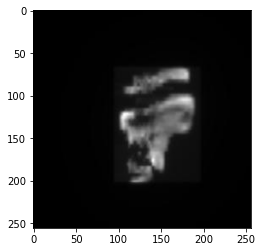

In [16]:
path = row['full_filename_jpeg']
im = read_image(path)
plt.imshow(im)

In [17]:
im.shape

(256, 256, 3)

In [18]:
# channel 0
np.min(im[:,:,0]), np.max(im[:,:,0])

(0, 255)

In [19]:
mask = np.random.random(len(maps_out)) < 0.8
train_maps = maps_out[mask].copy()
valid_maps = maps_out[~mask].copy()

In [20]:
len(maps_out), len(train_maps), len(valid_maps) 

(3995, 3194, 801)

## Dataset

In [21]:
def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    """
    # Image must be casted to float32 first
    image = image.astype('float')
    image = (image/255.0)
    return image

In [22]:
def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    """
    # Image must be casted to float32 first
    image = image.astype('float')
    # Rescale image from [0, 255] to [0, 2], and by substracting -1 we rescale to [-1, 1].
    image = (image/127.5) - 1
    return image

In [23]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    imagenet_stats = np.array([mean, std])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [24]:
class FluenceMapsDataset(Dataset):
    def __init__(self, maps):
        self.num_maps = len(maps)
        self.maps = maps
        
    def __len__(self):
        return self.num_maps
    
    def __getitem__(self, index):
        row = self.maps.iloc[index,:]
        y = row['gamma_index']
        path = str(row['full_filename_jpeg'])
        x = read_image(path)
        x = rescale_0_to_1(x)
        # x = normalize(x) # do not normalize, model performance is lower.
        # rollaxis: (256, 256, 3) => (3, 256, 256)
        return np.rollaxis(x, 2), y[None], path # y[None] converts y to numpy.ndarray 

In [25]:
train_ds = FluenceMapsDataset(train_maps)
valid_ds = FluenceMapsDataset(valid_maps)

In [26]:
x, y, f = train_ds[0]
x.shape, y, f

((3, 256, 256),
 array([99.9950589]),
 '/home/pablo/datasets/data/radioterapia/ciolaplata/2019-jpeg/1.3.6.1.4.1.9590.100.1.2.189485955411711008602298833212808936348.jpeg')

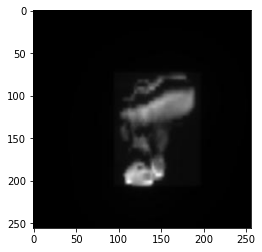

In [27]:
row = train_maps.iloc[0,:]
path = row['full_filename_jpeg']
im = read_image(path)
plt.imshow(im)

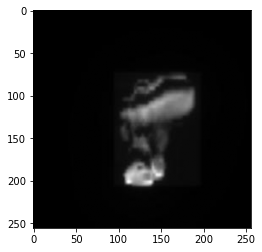

In [28]:
x = np.rollaxis(x, 2)
x = np.rollaxis(x, 2)
plt.imshow(x)

In [29]:
x, y, _ = valid_ds[0]
x.shape, y

((3, 256, 256), array([99.87318]))

In [30]:
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=8)

In [31]:
len(train_ds)

3194

In [32]:
len(train_loader)

100

In [33]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

## Model

In [34]:
#conda install ipywidgets
resnet = models.resnet18(pretrained=True)
#resnet 

In [35]:
layers = list(resnet.children())
print(len(layers))
# layers[-2:]
for i in range(len(layers)):
    print (f"-----------------------layer {i}-----------------------")
    print(layers[i])
    
# we want to freeze the fc2 layer this time: only train fc1 and fc3
#net.fc2.weight.requires_grad = False
#net.fc2.bias.requires_grad = False

#for param in resnet.parameters():
#    param.requires_grad = True
    
#layers[0].weight.requires_grad = False
#layers[1].requires_grad = False
#layers[4][0].conv1.weight.requires_grad = False
#layers[4][0].conv2.weight.requires_grad = False

#for param in resnet.parameters():
#    print(param.shape, param.requires_grad)

10
-----------------------layer 0-----------------------
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
-----------------------layer 1-----------------------
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
-----------------------layer 2-----------------------
ReLU(inplace=True)
-----------------------layer 3-----------------------
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
-----------------------layer 4-----------------------
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64,

In [36]:
# see https://discuss.pytorch.org/t/pytorch-equivalent-of-keras/29412
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512,1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [37]:
model = Net().cuda()

In [38]:
x, y, _ = next(iter(train_dl))

In [39]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([32, 3, 256, 256])

In [40]:
x_features = model.features1(x)
x_features.shape

torch.Size([32, 128, 32, 32])

In [41]:
x_features2 = model.features2(x_features)
x_features2.shape

torch.Size([32, 512, 8, 8])

In [42]:
x_features2 = F.relu(x_features2)

In [43]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features2)
x_features_ave.shape

torch.Size([32, 512, 1, 1])

In [44]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([32, 512])

In [45]:
y_hat = model(x)
y_hat.shape

torch.Size([32, 1])

In [46]:
# L1Loss (MAE), see https://pytorch.org/docs/master/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
F.l1_loss(y_hat, y)

tensor(99.2205, device='cuda:0', grad_fn=<L1LossBackward>)

In [47]:
y.shape

torch.Size([32, 1])

In [48]:
# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = False
#    
#for param in model.parameters():
#    print(param.requires_grad)

## Checking Loss function
Let's write the loss function from scratch in numpy to check the pytorch function.

## Learning rate finder

From this paper https://arxiv.org/pdf/1506.01186.pdf. This an implementation of the "LR range test". Run your model for several epochs while letting the learning rate increase linearly between low and high LR values. Next, plot the loss versus learning rate. Note the learning rate value when the loss starts to decrease and when the loss slows, becomes ragged, or increases. In the example below the range seem to be from 1e-5 to 0.012.

In [49]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    #for param in model.parameters():
    #    print(param.requires_grad)
    return optim.Adam(params, weight_decay=1e-5)
    #return optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), weight_decay=1e-5)

    
def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [50]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))


def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.01, epochs=3):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    print(f"train size: {len(train_dl)}, no. iter: {iterations}, lr_high - lr_low: {lr_high - lr_low}, delta: {delta}")
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    optimizer = create_optimizer(model, lrs[0])
    ind = 0
    for i in range(epochs):
        for x, y, _ in train_dl:
            lr = lrs[ind]
            # print(f"lr: {lr}")
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses    

In [51]:
# >>> create model >>>
model = Net().cuda()
# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = False

lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.3)

train size: 100, no. iter: 300, lr_high - lr_low: 0.29999, delta: 0.0009999666666666667


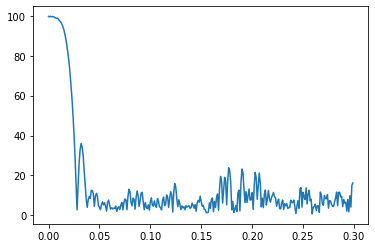

In [52]:
plt.plot(lrs, losses)
plt.show()

## Triangular learning rate training

In [53]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    # print(f"i: {i}, c_i: {c_i}, res: {end_lr + (start_lr - end_lr)/2 *c_i}")
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    print(f"min_start: {min_start:.3e}, min_end: {min_end:.3e}, iter1: {iter1}, iter2: {iter2}")
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

min_start: 4.000e-05, min_end: 4.000e-09, iter1: 600, iter2: 1400


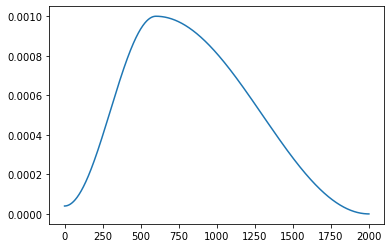

In [54]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [55]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x, y, _ in train_dl:
        lr = lrs[idx]
        # print(f"lr: {lr}")
        update_optimizer(optimizer, [lr/9, lr/3, lr])
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.l1_loss(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total, idx

In [56]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f" % (train_loss, val_loss))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            if val_loss < 1.0: # only save model file if val MAE < 1.0
                path = "{0}/models/model_resnet18_{1:.3f}.pth".format(PATH, val_loss)
                save_model(model, path)
                print(path)

In [57]:
# changed for regression
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    with torch.no_grad():
        for x, y, _ in valid_dl:
            # x and y are tensors, x.shape is [64, 3, 256, 256] and y.shape is [64, 1]
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x) # out is a tensor with shape [64, 1]
            y = y.float()
            loss = F.l1_loss(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total

## Training with triangular rates

In [58]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [59]:
model = Net().cuda()

In [60]:
val_metrics(model, valid_dl)

99.61432910590582

In [61]:
# create models directory under /home/pablo/datasets/data/invasive-species-monitoring/ first time
# same for /home/pablo/datasets/data/radioterapia/ciolaplata/models/
model = Net().cuda()
# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = False
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.008, epochs = 5)

min_start: 3.200e-04, min_end: 3.200e-08, iter1: 150, iter2: 350
train_loss 84.722 val_loss 1570.957
train_loss 1.735 val_loss 0.757
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.757.pth
train_loss 0.507 val_loss 0.603
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.603.pth
train_loss 0.479 val_loss 0.582
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.582.pth
train_loss 0.370 val_loss 0.458
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.458.pth


In [62]:
model = Net().cuda()

# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = True

#for param in model.features2.parameters():
#    param.requires_grad = True
    
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.008, epochs = 8)

min_start: 3.200e-04, min_end: 3.200e-08, iter1: 240, iter2: 560
train_loss 95.549 val_loss 74.602
train_loss 15.252 val_loss 0.806
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.806.pth
train_loss 0.618 val_loss 7.378
train_loss 0.739 val_loss 1.802
train_loss 0.448 val_loss 1.274
train_loss 0.440 val_loss 1.582
train_loss 0.384 val_loss 0.713
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.713.pth
train_loss 0.356 val_loss 0.550
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.550.pth


In [63]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.008, epochs = 10)

min_start: 3.200e-04, min_end: 3.200e-08, iter1: 300, iter2: 700
train_loss 97.259 val_loss 85.644
train_loss 26.774 val_loss 9.140
train_loss 0.879 val_loss 57.601
train_loss 0.647 val_loss 11.468
train_loss 0.619 val_loss 1.197
train_loss 0.506 val_loss 8.300
train_loss 0.482 val_loss 0.569
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.569.pth
train_loss 0.436 val_loss 0.533
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.533.pth
train_loss 0.389 val_loss 0.458
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.458.pth
train_loss 0.357 val_loss 0.459


In [64]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.008, epochs = 15)

min_start: 3.200e-04, min_end: 3.200e-08, iter1: 450, iter2: 1050
train_loss 98.538 val_loss 92.359
train_loss 56.386 val_loss 894.340
train_loss 0.859 val_loss 1.010
train_loss 0.620 val_loss 0.589
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.589.pth
train_loss 0.595 val_loss 2.148
train_loss 0.617 val_loss 0.591
train_loss 0.565 val_loss 2.263
train_loss 0.559 val_loss 2.793
train_loss 0.570 val_loss 1.015
train_loss 0.522 val_loss 0.621
train_loss 0.434 val_loss 0.706
train_loss 0.405 val_loss 1.318
train_loss 0.380 val_loss 0.479
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.479.pth
train_loss 0.355 val_loss 0.541
train_loss 0.343 val_loss 0.484


## Load a model

In [65]:
def get_predictions_df(model, valid_dl):
    model.eval()
    pred = []
    with torch.no_grad():
        for x, y, file in valid_dl:
            # x and y are tensors, x.shape is [BATCH_SIZE, 3, 256, 256] and y.shape is [BATCH_SIZE, 1]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x) # out is a tensor with shape [BATCH_SIZE, 1]
            # a.cpu().numpy() == float(a.cpu().numpy())
            batch_pred = [(Path(f).name, a.cpu().item(), b.cpu().item()) for f, a, b in zip(file, y, out)]
            pred = pred + batch_pred
    # build a pandas dataframe with results
    df = pd.DataFrame(pred, columns=['filename', 'actual gamma', 'predicted gamma'])
    return df

In [66]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [67]:
# load model
mae = 0.458
model = Net().cuda()
p = PATH/"models/model_resnet18_{}.pth".format(mae)
load_model(model, p)

In [68]:
val_metrics(model, train_dl)

0.35274032659656046

In [69]:
val_metrics(model, valid_dl)

0.45803767286436387

In [72]:
part = "validation" # training or validation
if part == "validation":
    df = get_predictions_df(model, valid_dl)
else:
    df = get_predictions_df(model, train_dl)            
df.head()

,filename,actual gamma,predicted gamma
0,1.3.6.1.4.1.9590.100.1.2.250681179813913418312...,99.873177,99.823013
1,1.3.6.1.4.1.9590.100.1.2.143145627012210047237...,100.000000,99.843025
2,1.3.6.1.4.1.9590.100.1.2.378149831812545674138...,99.677559,99.883636
3,1.3.6.1.4.1.9590.100.1.2.302383480412871360932...,99.972778,99.880783
4,1.3.6.1.4.1.9590.100.1.2.818237160113817578140...,99.940521,99.875526


In [73]:
p = PATH/"predictions/model_resnet18_{}_{}.csv".format(mae, part)
df.to_csv(p, index=False)

## Testing time augmentation
Testing time augmentation is a technique that uses data aumentation at test time to improve the test predictions. This usually helps but here our accuracy is too high.

_Pablo: Since we are not doing data augmentation for fluence maps, then testing time augmentation neithe applies_

## Lab
Can you get better accuracy?
* Change some of the hyperparameters (add dropout, increase the number of the hidden units)
* Increase the image resolution
* Modify the data augmentation to include other transformations

# References
This notebook is based on https://github.com/yanneta/deep-learning-data-institute/blob/master/lesson5-image-cnn.ipynb from course "Fundamentals of Deep Learning with Pytorch"